# Part 1 (CNN Model)

In [2]:
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import tarfile
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import pathlib
from keras.models import load_model
import shutil
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,Conv2D,Activation,MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
import seaborn as sns
from keras import backend as K
from keras.models import Model
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from matplotlib import cm
from sklearn.metrics import confusion_matrix,f1_score

In [3]:
print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



2022-05-06 18:55:59.217388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 18:56:00.342094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 18:56:00.342758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 18:56:00.348936: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2022-05-06 18:56:00.350907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 18:56:00.351599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 18:56:00.352194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 18:56:22.867075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 18:56:22.867738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

# Import Data

In [4]:
################################# 
#untar files and save in ./Images
#################################

# file_count = 3 # only first three 

# for i in range(file_count):
#     file = tarfile.open('images_00'+i+'.tar.gz')
#     file.extractall('./Images')
#     file.close()

In [5]:
# list of train and val images
train_val_idx = pd.read_csv('train_val_list.txt', header = None)
display(train_val_idx.head())
len(train_val_idx)

,0
0,00000001_000.png
1,00000001_001.png
2,00000001_002.png
3,00000002_000.png
4,00000004_000.png


86524

In [6]:
# list of test images
test_idx = pd.read_csv('test_list.txt', header = None)
display(test_idx.head())
len(test_idx)

,0
0,00000003_000.png
1,00000003_001.png
2,00000003_002.png
3,00000003_003.png
4,00000003_004.png


25596

In [7]:
# main dataframe
df = pd.read_csv("Data_Entry_2017_v2020.csv")
df_binary = df.copy()

In [8]:
##Code to revert Sick and NotSick to one Images folder

# source1 = "./Images/sick"
# dest = "./Images"
# source2 = "./Images/notsick"
# files = os.listdir(source1)
# # os.mkdir(dest1)
# # os.mkdir(dest2)}

# for f in files:
#     shutil.move(source1 + '/'+ f, dest + '/'+ f)
    
# files = os.listdir(source2)    
# for f in files:
#     shutil.move(source2 + '/'+ f, dest + '/'+ f)    


In [9]:
# delete folder sick
dir_path = "./Images/sick"

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

Error: ./Images/sick : No such file or directory


In [10]:
# delete folder not sick
dir_path = "./Images/notsick"

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

Error: ./Images/notsick : No such file or directory


# Pre-Processing

For pre-processing, ensure to separate data based on the patient ID to prevent data leakage. In addition, apply data augmentation techniques to ensure our model is more generalizable in other setting. However, only apply slight changes to images to prevent distorting of diagnosis. 

In [11]:
#OneHot Encode Labels
mlb = MultiLabelBinarizer()
df_binary['test']=df_binary['Finding Labels'].str.split("|")
df_processed = pd.concat([df_binary,pd.DataFrame(mlb.fit_transform(df_binary['test']),columns=mlb.classes_, index=df_binary.index)],axis=1)

In [12]:
df_processed.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0


In [13]:
# obtain df_train from df_processed
df_train = df_processed.loc[df_processed['Image Index'].isin(train_val_idx[0].values)]
df_train = df_train.drop(['Finding Labels', 'Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'test', 'No Finding'], axis = 1)
df_train.head()

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,00000004_000.png,4,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [14]:
# obtain df_test from df_processed
df_test = df_processed.loc[df_processed['Image Index'].isin(test_idx[0].values)]
df_test = df_test.drop(['Finding Labels', 'Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'test', 'No Finding'], axis = 1)
df_test.head()

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4,00000003_001.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,00000003_002.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,00000003_003.png,3,0,0,0,0,0,0,0,1,1,0,0,0,0,0
7,00000003_004.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,00000003_005.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [15]:
# split df_train into train and val (data leakage does not matter here)
df_train, df_val = train_test_split(df_train, test_size=0.2)

In [16]:
# Check for data leakage
train_patients = set(df_train['Patient ID'].values)
test_patients = set(df_test['Patient ID'].values)
patients_in_both_groups = train_patients.intersection(test_patients)
print("Check how many patients are in both train and test:")
len(patients_in_both_groups)

Check how many patients are in both train and test:


0

In [17]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [22]:
# how many total images we are using for train, val, test
im_dir = "./Images/"
print(f"{len([name for name in os.listdir(f'{im_dir}')])} images are in the Images/ folder")

25000 images are in the Images/ folder


In [19]:
def get_train_gen(df, image_dir, x, y, W, H, shuffle=True, batch_size=8, seed=1):
    
    image_gen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        height_shift_range= 0.05, 
        width_shift_range=0.05, 
        rotation_range=5, 
        shear_range = 0.05,
        zoom_range=0.15)

    generator = image_gen.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x,
            y_col=y,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(W,H))
    
    return generator

In [20]:
def get_test_and_valid_gen(val_df, test_df, train_df, image_dir, x, y, W, H, sample_size=100, batch_size=8, seed=1):

    raw_train_gen = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="Image Index", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(W, H))
    
    batch = raw_train_gen.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_gen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_gen.fit(data_sample)

 # val and test gen
    valid_gen = image_gen.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x,
            y_col=y,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(W,H))

    test_gen = image_gen.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x,
            y_col=y,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(W,))
    return valid_gen, test_gen

In [21]:
## create data generators
# set target dimensions
W = 128
H = 128
batch_size = 8
train_generator = get_train_gen(df_train, im_dir, "Image Index", labels, W, H, batch_size = batch_size)
valid_generator, test_generator= get_test_and_valid_gen(df_val, df_test, df_train, im_dir, "Image Index", labels, W, H, batch_size = batch_size)

/home/u_51535847/.local/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 52381 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  warnings.warn(


Found 16838 validated image filenames.


/home/u_51535847/.local/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 52381 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  warnings.warn(


Found 16838 validated image filenames.


/home/u_51535847/.local/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 13212 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  warnings.warn(


Found 4093 validated image filenames.
Found 4068 validated image filenames.


/home/u_51535847/.local/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 21528 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


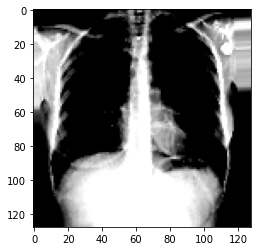

In [21]:
# visualize example
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])

# Data Exploration and Class Imbalance

Based on data exploration, noticed the class imbalance among different labels. I believe different gender group has different risk to certain diagnosis. However, since the X-ray could show the gender of a patient, I didn't think it was necessary to include information, such as gender, age, or race, in  model.

Because of the class imbalance shown above and due to the multi-task nature of our model, I will define a custom loss function that reweights the loss based on class frequency. In addition, I also modify the cost based on positive and negative classification frequencies. Therefore have a weighted multi-taks loss for the model.

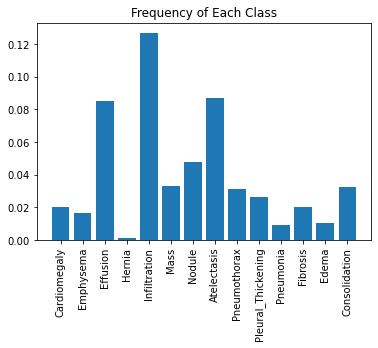

In [22]:
# check for class imbalance
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [23]:
freq_pos = np.sum(train_generator.labels, axis=0) / train_generator.labels.shape[0]
freq_neg = np.sum(train_generator.labels == 0, axis=0) / train_generator.labels.shape[0]

In [24]:
pos_weights = freq_neg
neg_weights = freq_pos

In [25]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            loss += -1 * K.mean((tf.cast(pos_weights[i], tf.float32) * tf.cast(y_true[:, i], tf.float32) * tf.cast(K.log(tf.cast(y_pred[:, i], tf.float32)),tf.float32) + epsilon) + 
                     tf.cast(neg_weights[i], tf.float32) * (1 - tf.cast(y_true[:, i], tf.float32)) * tf.cast(K.log(1 - tf.cast(y_pred[:, i], tf.float32) + epsilon),tf.float32))
        return loss        
    return weighted_loss

# Modeling

This is the CNN based model. I used DenseNet for transfer learning. A vision transformer model is also included in notebook 2.

In [29]:
# using pretrained DenseNet121 on ImageNet

base_model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(W,H,3)
)

In [30]:
# set first 50 layers to non trainable
for layer in base_model.layers[:50]:
    layer.trainable = False

In [31]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

In [32]:
x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks_list = [early_stopping]
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))
steps_per_epoch = len(train_generator) 
validation_steps = len(valid_generator) 

In [29]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=steps_per_epoch, 
                              validation_steps=validation_steps, 
                              epochs = 8,
                              callbacks = callbacks_list)

Epoch 1/8


2022-05-04 15:59:13.673522: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-04 16:00:17.780538: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2097/2097 [==============================] - 672s 238ms/step - loss: 0.7102 - val_loss: nan
Epoch 2/8
2097/2097 [==============================] - 373s 178ms/step - loss: 0.6888 - val_loss: 0.8275
Epoch 3/8
2097/2097 [==============================] - 373s 178ms/step - loss: 0.6618 - val_loss: 0.6894
Epoch 4/8
2097/2097 [==============================] - 372s 178ms/step - loss: 0.6440 - val_loss: 0.6448
Epoch 5/8
2097/2097 [==============================] - 373s 178ms/step - loss: 0.6337 - val_loss: 0.6695
Epoch 6/8
2097/2097 [==============================] - 374s 178ms/step - loss: 0.6228 - val_loss: 0.7327
Epoch 6: early stopping


In [30]:
# model.save('model_densenet121')

2022-05-04 16:40:55.777339: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_densenet121/assets


In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

/tmp/ipykernel_61/2350575586.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))


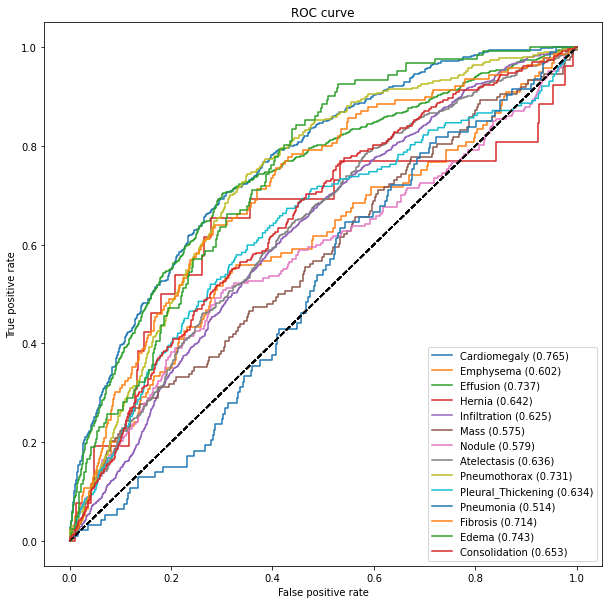

In [32]:
# plot auc roc curves per diagnosis
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
auc_roc_vals = []
for i in range(len(labels)):
    gt = test_generator.labels[:, i]
    pred = predicted_vals[:, i]
    auc_roc = roc_auc_score(gt, pred)
    auc_roc_vals.append(auc_roc)
    fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
    plt.figure(1, figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
plt.show()


In [33]:
f1_scores
y_true = test_generator.labels
y_pred = predicted_vals
f1s = []
for i in range(14):
    f1 = f1_score(y_true[:,i],y_pred[:,i]<0.5)
    f1s.append(f1)
f1s    

# Saliency Maps

In [34]:
# find images with just one pathology, e.g. cardiomegaly here
images_in_f = [name for name in os.listdir('./Images/')]
df_processed_filtered = df_processed.loc[df_processed['Image Index'].isin(np.array(images_in_f))]
df_processed_filtered[df_processed_filtered['Finding Labels']=='Cardiomegaly'].head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
23,00000008_000.png,Cardiomegaly,0,8,68,F,PA,2048,2500,0.171,...,0,0,0,0,0,0,0,0,0,0
61,00000013_045.png,Cardiomegaly,23,13,56,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
114,00000032_000.png,Cardiomegaly,0,32,54,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
135,00000032_021.png,Cardiomegaly,21,32,54,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0


In [35]:
image_dir = './Images/'
img = '00000032_053.png'
H,W = 128,128

df_truth = pd.read_csv('Data_Entry_2017_v2020.csv')
label_true = list(df_truth['Finding Labels'][df['Image Index'] ==img])[0]
idx = labels.index(label_true)

#label_true = df_truth['Finding Labels'][df['Image Index'] ==x]

img_path = image_dir + img
x = image.load_img(img_path, target_size=(H, W))
x = np.array(x)
x = x/255.

labels_to_show = np.take(labels, np.argsort(auc_roc_vals)[::-1])[:4]


In [36]:
bbox = pd.read_csv('BBox_List_2017.csv')
# bbox[bbox['Image Index'] == '00000032_024.png']

The below image is for a patient with Cardiomegaly diagnosis


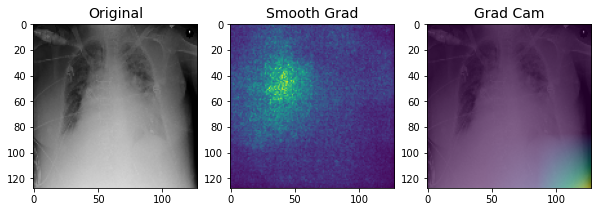

In [37]:
def linear(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
def score_function(output):
    return (output[1][idx])

# score = CategoricalScore(8)

score = lambda x: x[:, idx]

fig, axs = plt.subplots(1,3, figsize=(10,10))
axs = axs.ravel()

saliency = Saliency(model,
                    model_modifier=linear,
                    clone=True)
saliency_map = saliency(score,
                        x,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              x,
              penultimate_layer=-1)
heatmap = np.uint8(cm.viridis(cam[0])[..., :3] * 255)
# Render
axs[0].imshow(x)
axs[0].set_title('Original', fontsize=14)

axs[1].set_title('Smooth Grad', fontsize=14)
axs[1].imshow(saliency_map[0], cmap='viridis')

axs[2].set_title('Grad Cam', fontsize=14)
axs[2].imshow(x)
axs[2].imshow(heatmap, cmap='viridis', alpha=0.5) # overlay

print(f'The below image is for a patient with {label_true} diagnosis')

### Summary

Noticed that CNN model has descent performance, since the average AUC score is 0.687.

For saliency maps, noticed that Grad Cam was trying the detect the correct region for Cardiomegaly, which is enlarged heart. However, the area was slightly lower than the medical region. Smooth Grad was more looking at the lung area rather than the heart.

In [38]:
# # Delete hidden ipynb checkpoints files

# file_path = './Images/.ipynb_checkpoints'
# try:
#     shutil.rmtree(file_path)
# except:
#     print('No such files')

# path = './Images'
# my_data = os.listdir(path)
# # print(my_data)

## Continued in VIT-Part 2 notebook ^_^